In [1]:
import numpy as np
from hmmlearn import hmm
import warnings
from sklearn import neighbors, preprocessing
import pandas as pd
import seaborn as sns
import pprint


from analytic import utility, ta_indicators, statistics, visual

import math
from matplotlib import cm
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from scipy import stats

# please run $ jupyter notebook at "udacity/_p_f/src" folder

/home/boweiliu/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
symbols = ('AMAT', )
csv_files = [utility.get_appropriate_file(symbol) for symbol in symbols]
requested_col = ['time', 'high', 'low', 'open', 'close']
the_df = utility.get_cols_from_csv_names(file_names=csv_files,
                                         interested_col=requested_col,
                                         join_spy_for_data_integrity=False,
                                         keep_spy_if_not_having_spy=False,
                                         base_dir="./rawdata")
daily_grp = the_df.groupby(pd.Grouper(level=0, freq='1d'))
daily_rtn = (daily_grp['AMAT_CLOSE'].last() - daily_grp['AMAT_OPEN'].first()) / daily_grp['AMAT_OPEN'].first()
daily_rtn = daily_rtn.dropna()
daily_rtn.name = "AMAT_RTN"

rocp = ta_indicators.get_rocp(the_df['AMAT_CLOSE'], '60s', None, expanding=True)

# get rolling t-test
rocp_mean = rocp.mean()
rocp_std = rocp.std()
rocp_nobs = len(rocp)
kwargs = {
    "mean2": rocp_mean,
    "std2": rocp_std,
    "nobs2": rocp_nobs
}
print("rocp_mean: {0:.9f}, rocp_std: {1:.9f}, rocp_nobs: {2:d}".format(
    rocp_mean, rocp_std, rocp_nobs))




rocp_mean: -0.000002602, rocp_std: 0.000831548, rocp_nobs: 58140


A slump, the purpose of this algorithm
AMAT 2017-11-17


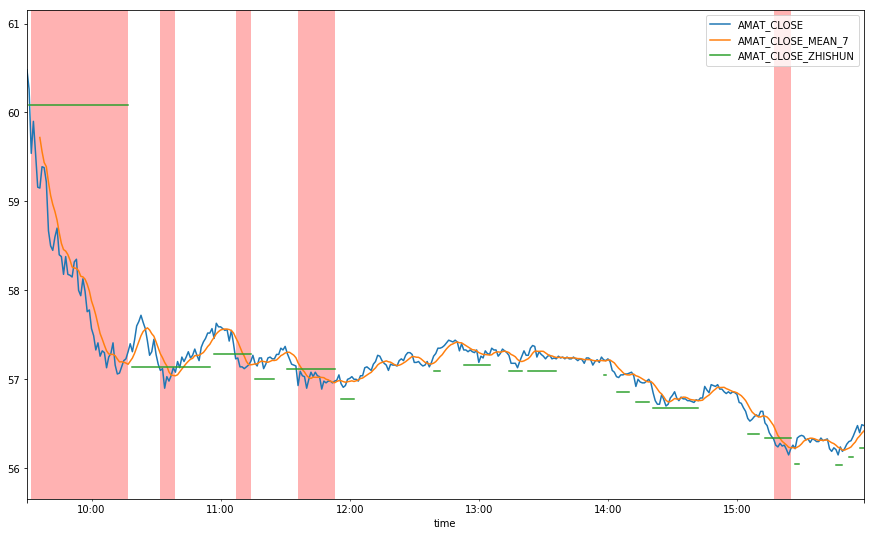

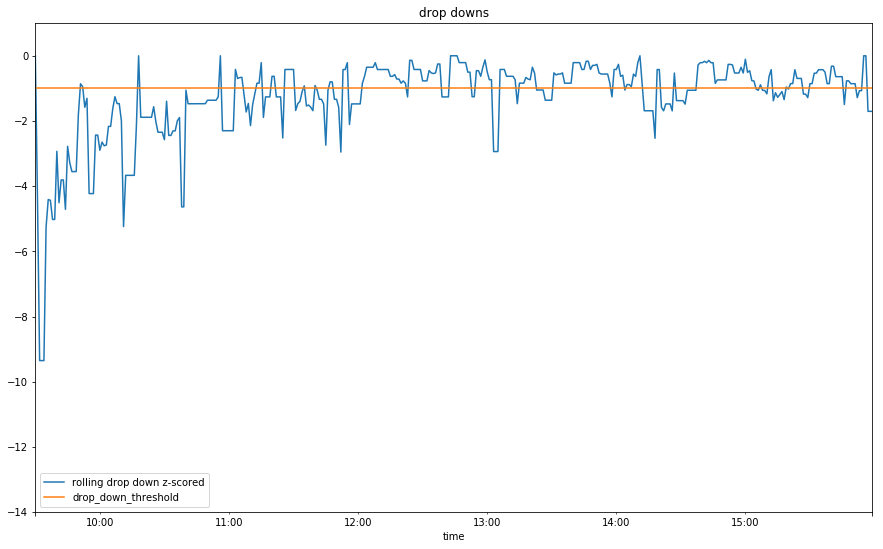

In [9]:
kwargs = {
    "mean2": rocp_mean,
    "std2": rocp_std,
    "nobs2": rocp_nobs
}
col_name_map = {
    'open': 'AMAT_OPEN',
    'high': 'AMAT_HIGH',
    'low': 'AMAT_LOW',
    'close': 'AMAT_CLOSE',
}
# 2017-11-13  -> 2017-11-20, 2017-11-17 da die

selected_date = '2017-11-17'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ma = ta_indicators.get_rolling_mean(closes_of_selected, 7)
ma_rocp_2 = ta_indicators.get_rocp(ma, 2)

ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5))
ma.plot(ax=ax, legend=True)

drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
drop_downs.name = "rolling drop down z-scored"
# print(drop_downs.head(30))

zhishun_line = ta_indicators.get_zhishun(
    in_ser=closes_of_selected, 
    should_zhishun=drop_downs <= -1, 
    should_stop_zhishun=ma_rocp_2 >= 0.0, buffer=0.003)

zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected < zhishun_line).values, 
                facecolor='red', alpha=0.3, transform=trans)
print("A slump, the purpose of this algorithm")
print("AMAT {}".format(selected_date))
plt.show()

ax = drop_downs.plot(title="drop downs", legend=True, figsize=(15, 9), ylim=(-14, 1))
drop_down_threshold = pd.Series(np.ones((390), dtype=np.float32),
                                index=drop_downs.index).multiply(-1)
drop_down_threshold.name = "drop_down_threshold"
drop_down_threshold.plot(ax=ax, legend=True)
plt.show()


a special case which triggered many transactions, needs to take a look
AMAT 2017-08-18


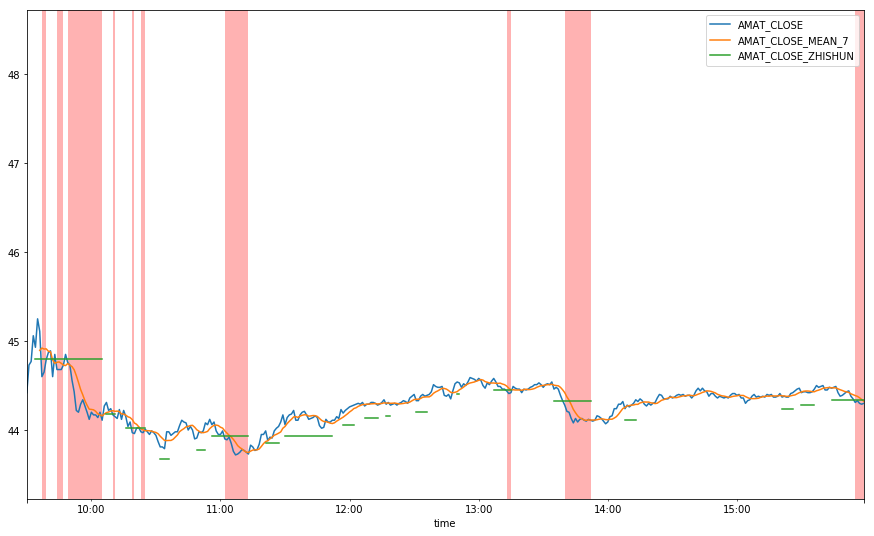

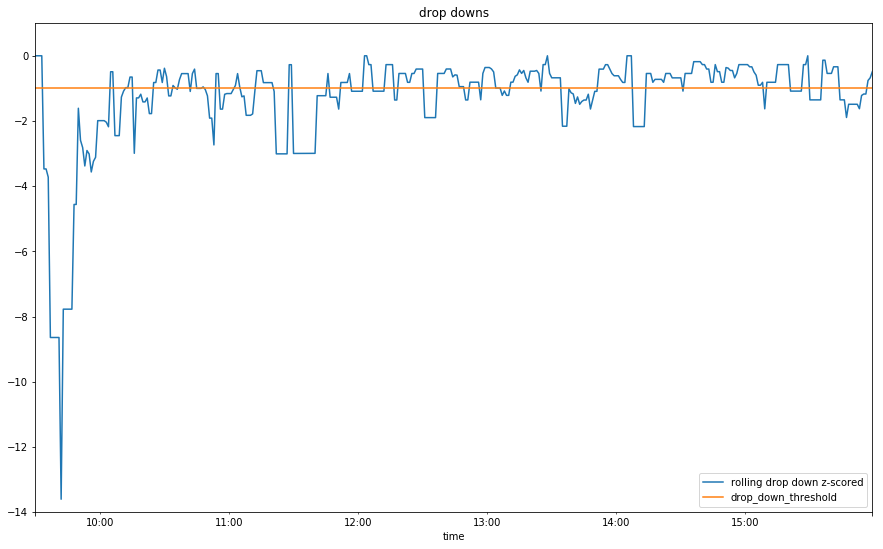

In [15]:
selected_date = '2017-08-18'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ma = ta_indicators.get_rolling_mean(closes_of_selected, 7)
ma_rocp_2 = ta_indicators.get_rocp(ma, 2)

ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5),
                             grid=True)
ma.plot(ax=ax, legend=True)
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
drop_downs.name = "rolling drop down z-scored"


zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, 
    drop_downs <= -1.0,
    ma_rocp_2 >= 0.0,
    buffer=0.003)
zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected <= zhishun_line).values, 
                facecolor='red', alpha=0.3, transform=trans)
print("a special case which triggered many transactions, needs to take a look")
print("AMAT {}".format(selected_date))
plt.show()

ax = drop_downs.plot(title="drop downs", legend=True, figsize=(15, 9), 
                     ylim=(-14, 1), 
                     grid=True)
drop_down_threshold = pd.Series(np.ones((390), dtype=np.float32),
                                index=drop_downs.index).multiply(-1)
drop_down_threshold.name = "drop_down_threshold"
drop_down_threshold.plot(ax=ax, legend=True)
plt.show()

normal no up no go down
AMAT 2017-10-04


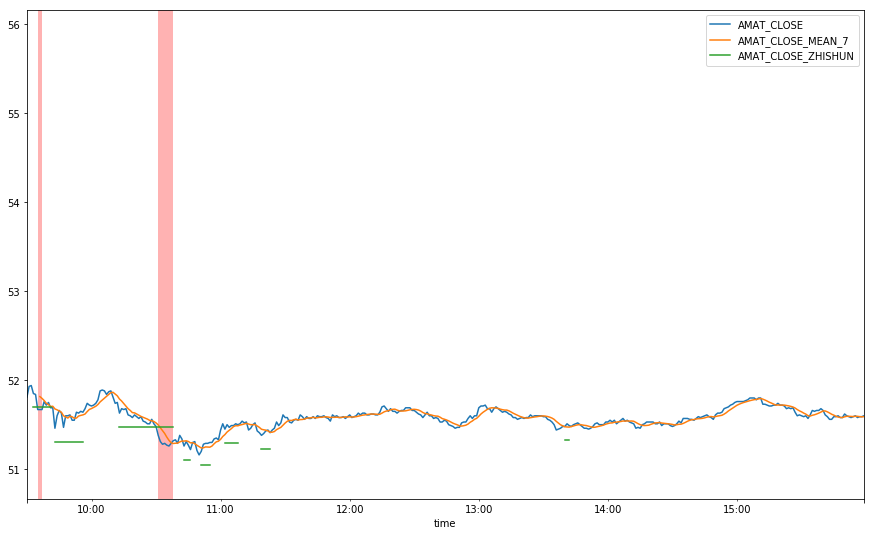

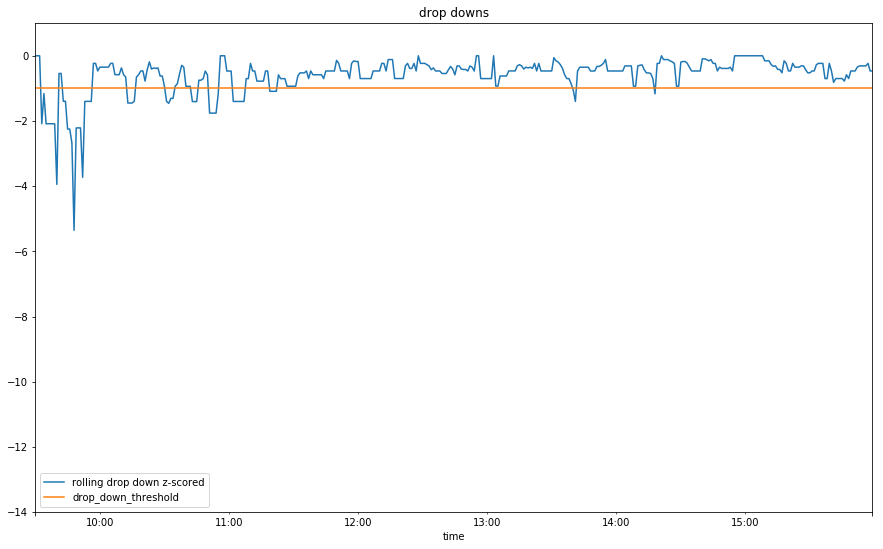

In [18]:
selected_date = '2017-10-04'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ma = ta_indicators.get_rolling_mean(closes_of_selected, 7)
ma_rocp_2 = ta_indicators.get_rocp(ma, 2)

ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5),
                             grid=True)
ma.plot(ax=ax, legend=True)
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
drop_downs.name = "rolling drop down z-scored"


zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, 
    drop_downs <= -1.0,
    ma_rocp_2 >= 0.0,
    buffer=0.003)
zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected <= zhishun_line).values, 
                facecolor='red', alpha=0.3, transform=trans)
print("normal no up no go down")
print("AMAT {}".format(selected_date))
plt.show()

ax = drop_downs.plot(title="drop downs", legend=True, figsize=(15, 9), 
                     ylim=(-14, 1), 
                     grid=True)
drop_down_threshold = pd.Series(np.ones((390), dtype=np.float32),
                                index=drop_downs.index).multiply(-1)
drop_down_threshold.name = "drop_down_threshold"
drop_down_threshold.plot(ax=ax, legend=True)
plt.show()

normal go down
AMAT 2017-12-04


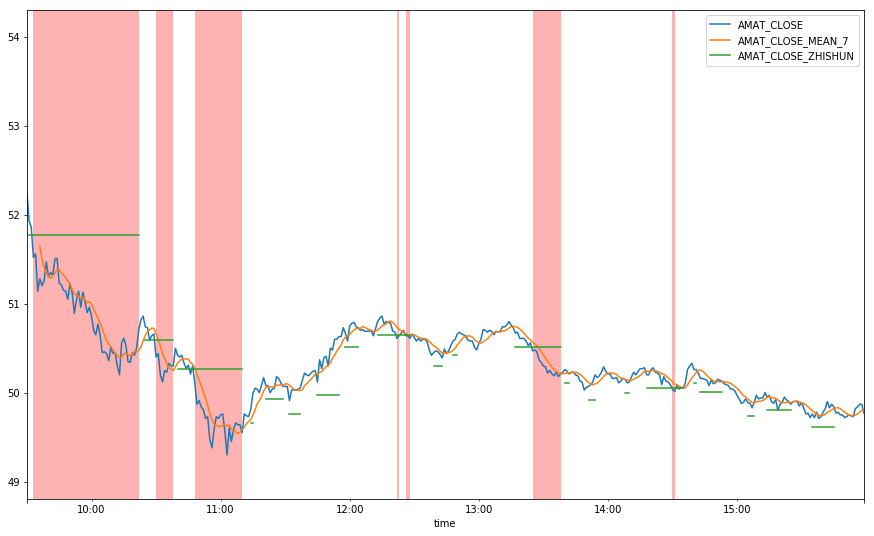

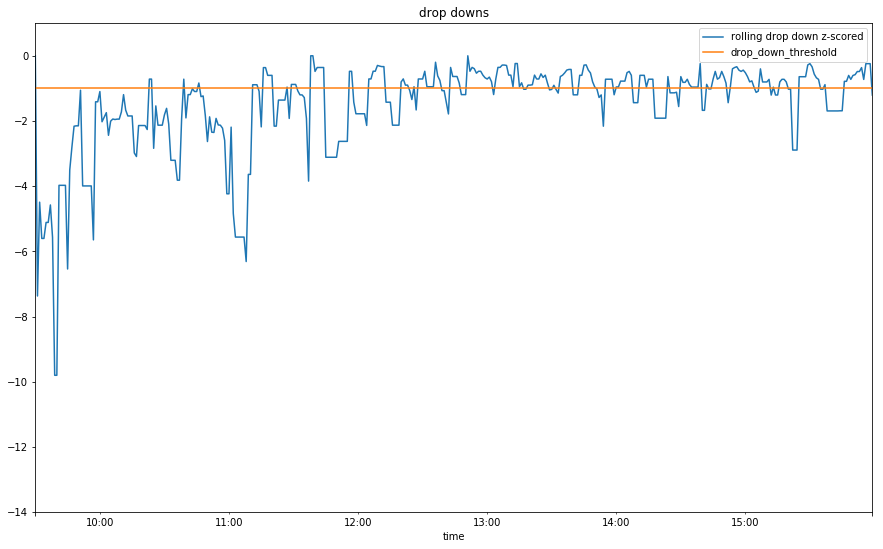

In [17]:
selected_date = '2017-12-04'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ma = ta_indicators.get_rolling_mean(closes_of_selected, 7)
ma_rocp_2 = ta_indicators.get_rocp(ma, 2)

ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5),
                             grid=True)
ma.plot(ax=ax, legend=True)
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
drop_downs.name = "rolling drop down z-scored"


zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, 
    drop_downs <= -1.0,
    ma_rocp_2 >= 0.0,
    buffer=0.003)
zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected <= zhishun_line).values, 
                facecolor='red', alpha=0.3, transform=trans)
print("normal go down")
print("AMAT {}".format(selected_date))
plt.show()

ax = drop_downs.plot(title="drop downs", legend=True, figsize=(15, 9), 
                     ylim=(-14, 1), 
                     grid=True)
drop_down_threshold = pd.Series(np.ones((390), dtype=np.float32),
                                index=drop_downs.index).multiply(-1)
drop_down_threshold.name = "drop_down_threshold"
drop_down_threshold.plot(ax=ax, legend=True)
plt.show()

normal up
AMAT 2017-10-06


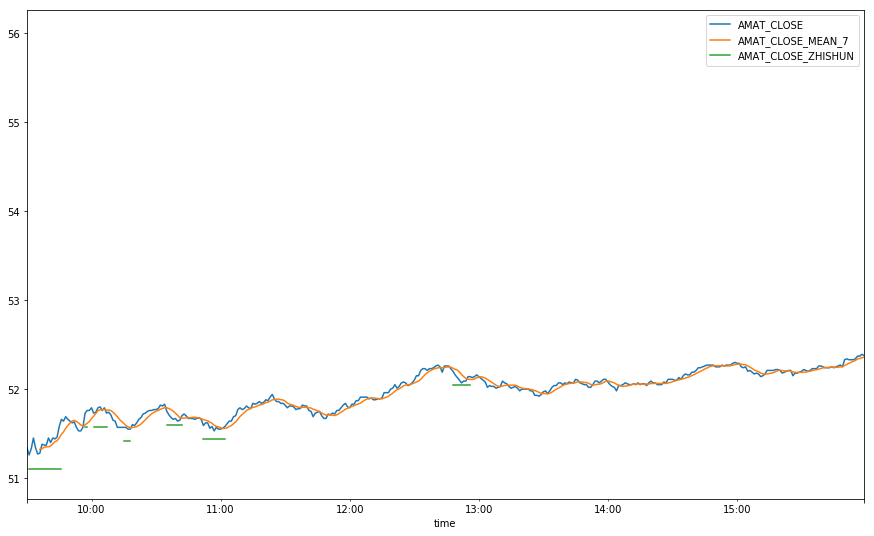

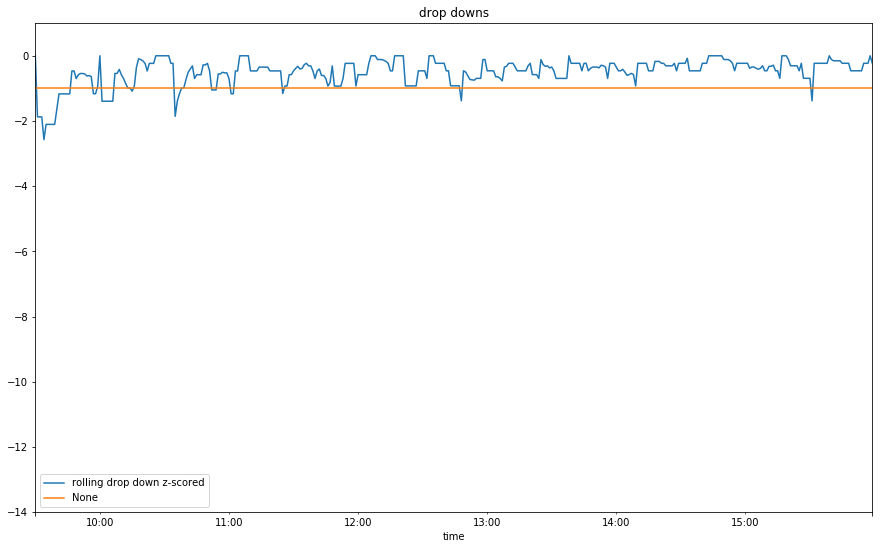

In [13]:
selected_date = '2017-10-06'
the_df_selected = the_df.loc[selected_date]
closes_of_selected = the_df_selected['AMAT_CLOSE']
ma = ta_indicators.get_rolling_mean(closes_of_selected, 7)
ma_rocp_2 = ta_indicators.get_rocp(ma, 2)

ax = closes_of_selected.plot(figsize=(15, 9), legend=True, 
                             ylim=(closes_of_selected.min() - 0.5, 
                                   closes_of_selected.min() + 5),
                             grid=True)
ma.plot(ax=ax, legend=True)
drop_downs = closes_of_selected.rolling(window=7, min_periods=1)\
    .apply(statistics.drop_down, kwargs=kwargs)
drop_downs.name = "rolling drop down z-scored"


zhishun_line = ta_indicators.get_zhishun(
    closes_of_selected, 
    drop_downs <= -1.0,
    ma_rocp_2 >= 0.0,
    buffer=0.003)
zhishun_line.plot(ax=ax, legend=True)
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(closes_of_selected.index, 
                0, 1,
                where=(closes_of_selected <= zhishun_line).values, 
                facecolor='red', alpha=0.3, transform=trans)
print("normal up")
print("AMAT {}".format(selected_date))
plt.show()

ax = drop_downs.plot(title="drop downs", legend=True, figsize=(15, 9), 
                     ylim=(-14, 1), 
                     grid=True)
drop_down_threshold = pd.Series(np.ones((390), dtype=np.float32),
                                index=drop_downs.index).multiply(-1)
drop_down_threshold.name = "drop_down_threshold"
drop_down_threshold.plot(ax=ax, legend=True)
plt.show()